In [1]:
# modification of the original ipynb notebook 
#https://github.com/higgsfield/Capsule-Network-Tutorial/blob/master/Capsule%20Network.ipynb
#https://github.com/aliasvishnu/Capsule-Networks-Notebook-MNIST
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = False

<p><b>NOTE:</b><br>
All thanks to Mr. Kenta (seriously). However, I've made certain changes to speed up the code a little, and make the code more in line with the paper.</p>
<p> Also, this notebook only talks about the classification portion, not the reconstruction. </p> <br>
Basically, there are 3 layers.
<ul>
<li>Convolution Layer</li>
<li>Convolution Capsule Layer (PrimaryCaps)</li>
<li>Capsule Layer (DigitCaps) </li>
</ul>

<img src = "images/arch.png">

Let's look at this one by one.

##### Capsule Convolutional Layer

In [2]:
class ConvCaps2D(nn.Module):
    def __init__(self):
        super(ConvCaps2D, self).__init__()
        # The paper suggests having 32 8D capsules
        self.capsules = nn.ModuleList([nn.Conv2d(in_channels = 256, out_channels = 8, kernel_size=9, stride=2)
                                       for _ in range(32)])
        
    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm) # scale.size()  is (None, 1152, 1)  
        return scale*tensor / torch.sqrt(norm)
        
    def forward(self, x):
        outputs = [capsule(x).view(x.size(0), 8, -1) for capsule in self.capsules] # 32 list of (None, 1, 8, 36)
        outputs = torch.cat(outputs, dim = 2).permute(0, 2, 1)  # outputs.size() is (None, 1152, 8)
        return self.squash(outputs)


In [3]:
class Caps1D(nn.Module):
    def __init__(self):
        super(Caps1D, self).__init__()
        self.num_caps = 10
        self.num_iterations = 3
        self.W = nn.Parameter(torch.randn(10, 1152, 8, 16))
        
    def softmax(self, x, dim = 1):
        transposed_input = x.transpose(dim, len(x.size()) - 1)
        softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
        return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(x.size()) - 1)

    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm)        
        return scale*tensor / torch.sqrt(norm)
   
    # Routing algorithm
    def forward(self, u):
        # u.size() is (None, 1152, 8)
        '''
        From documentation
        For example, if tensor1 is a j x 1 x n x m Tensor and tensor2 is a k x m x p Tensor, 
        out will be an j x k x n x p Tensor.
        
        We need j = None, 1, n = 1152, k = 10, m = 8, p = 16
        '''
        
        u_ji = torch.matmul(u[:, None, :, None, :], self.W) # u_ji.size() is (None, 10, 1152, 1, 16)
        
        if USE_CUDA:
            b = Variable(torch.zeros(u_ji.size())).cuda(gpu) # b.size() is (None, 10, 1152, 1, 16)
        else:
            b = Variable(torch.zeros(u_ji.size()))
        
        for i in range(self.num_iterations):
            c = self.softmax(b, dim=2)
            v = self.squash((c * u_ji).sum(dim=2, keepdim=True)) # v.size() is (None, 10, 1, 1, 16)

            if i != self.num_iterations - 1:
                delta_b = (u_ji * v).sum(dim=-1, keepdim=True)
                b = b + delta_b
        
        # Now we simply compute the length of the vectors and take the softmax to get probability.
        v = v.squeeze()
        classes = (v ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=0) # This is not done in the paper, but I've done this to use CrossEntropyLoss.
        
        return classes
if USE_CUDA:
    net = Caps1D().cuda(gpu)
else:
    net=Caps1D()
# sum(net.forward(Variable(torch.Tensor(np.random.rand(1, 1152, 8)).cuda(gpu))))

In [4]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 256, kernel_size = 9, stride = 1)
        
        self.primaryCaps = ConvCaps2D()
        self.digitCaps = Caps1D()
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        
        return x
if USE_CUDA:
    net = CapsNet().cuda(gpu)
else:
    net=CapsNet()

In [5]:
def evaluate(model, X, Y, batch_size = 200):
    """
    X is a torch float tensor made from sampler
    y is also a torch long tensor made from sampler
    """
    results = []
    predicted = []
    
    inputs=Variable(X)
    
        
    #inputs = Variable(torch.from_numpy(X[s:e]).cuda(gpu))
    pred = model(inputs)
    #print("pred",pred)
    #print("argmax",np.argmax(pred.data.cpu().numpy(), axis = 1))
    predicted= list(np.argmax(pred.data.cpu().numpy(), axis = 1))
    #print(type(predicted))
    
    acc = sum([1 if t1==t2 else 0 for t1,t2 in zip(predicted, Y)])*1.0/(len(Y))
    return acc

In [ ]:

t1=list(Variable(tr_labels).data.numpy())
out=net(Variable(tr_batches))
t2=list(np.argmax(out.data.cpu().numpy(), axis = 1))
evaluate(net,t1,t2)

In [ ]:
sum([1 if x == y else 0 for x,y in zip(t1,t2)])*1.0/(len(t2))

##### DigitCaps Layer
Most important thing here is the routing by agreement portion. I've used same variables as in the paper. <br>
<img src = 'images/form1.png' style = "width:400px;"><img src = 'images/form2.png' style = "width:250px;"><br>
<img src = 'images/alg1.png' style = "float:left">

##### Capsule Network
Now we just put together all of the above code.

Load the data

In [19]:
dataset = MNIST(root='./data', download=False, train=True)

X = np.expand_dims(getattr(dataset, 'train_data').numpy().astype('float32'), 1)/255.0
y = getattr(dataset, 'train_labels').numpy().astype('int64')

#indices = np.random.permutation(len(X_train))
#X_train = X_train[indices]
#y_train = y_train[indices]
print(X.shape, y.shape)

dataset = MNIST(root='./data', download=False, train=False)

X_test = np.expand_dims(getattr(dataset, 'test_data').numpy().astype('float32'), 1)/255.0
y_test = getattr(dataset, 'test_labels').numpy().astype('int64')


n=int(len(X_test))
indices = np.random.choice(n, int(n*0.8), replace=False)

print(indices.shape)
print(indices[:5])

X_train = X_test[indices]
y_train = y_test[indices]

not_idx=[x for x in range(n) if x not in indices]
print(len(not_idx))

X_test = X_test[not_idx]
y_test = y_test[not_idx]
X_train.shape, X_test.shape

(60000, 1, 28, 28) (60000,)
(8000,)
[1217 4112 7155 3131 4680]
2000


((8000, 1, 28, 28), (2000, 1, 28, 28))

In [7]:
from random import *
import random
class SampleMaker(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        event2torch=event[0]       
        event_label=event[1]       
        self.memory.append([event2torch,event_label])  
        if len(self.memory) > self.capacity:
            del self.memory[0]
    
    def make(self, batch_size):
        samples = random.sample(*(self.memory, batch_size))
       
        return samples

In [8]:

#populate the SampleMaker with all the 8000 training data
samplemaker=SampleMaker(capacity=8000)
for i in range(8000):
    #print(test_dat[i].shape, test_label[i].shape)
    samplemaker.push([X_train[i],y_train[i]])    


#populate the SampleMaker with all the 8000 training data
testmaker=SampleMaker(capacity=2000)
for i in range(2000):
    #print(test_dat[i].shape, test_label[i].shape)
    testmaker.push([X_test[i],y_test[i]])   

In [9]:
#converting types to pytorch tensors
import itertools
def type_converter(sam,batch_size , img_size):
    train_placeholder=np.empty((1,img_size,img_size),dtype=float,order='C')
    train_labels=np.empty((1,1),dtype=float,order='C')
    batch=map(lambda s: s[0],sam)
    #convert batch
    for o in enumerate(batch):
        #print(o[1].shape)
        train_placeholder=np.vstack((train_placeholder,o[1]))
    train_batches=np.delete(train_placeholder, 0, 0).reshape(batch_size,1,img_size,img_size) #delete the empty placeholder
    
    batch_labels=list(map(lambda s:s[1],sam))
    #print(len(batch_labels))
    batch_labels=[l.tolist() for l in batch_labels]#convert to list
    #print(len(batch_labels))
    #batch_labels=list(itertools.chain(*batch_labels))#flattern to flatlist
    batch_labels=[int(i) for i in batch_labels]#turn each inner-list type to int 
    #print(len(batch_labels))
    batch_labels=np.array(batch_labels, dtype=np.int64)#convert to np array
    #print(batch_labels.shape)
    #returning nd array for train batches and labels
    return train_batches,batch_labels

In [ ]:
sam=samplemaker.make(100)
list(map(lambda s:s[1],sam))

In [10]:
def torch_ready(batch_size,img_size, train):
    if train:
        samples=samplemaker.make(batch_size)
    else:
        samples=testmaker.make(batch_size)
    d,l=type_converter(samples,batch_size,img_size)
    data=torch.from_numpy(d).float()
    label=torch.from_numpy(l)
    return data , label

In [ ]:
#debug tryout
num_batches=1
batch_size=100
img_size=28

tr_batches, tr_labels=torch_ready(200,28,True)
#print(tr_batches.size())
#print(tr_labels.size())
out=model(Variable(tr_batches))  

#print(Variable(tr_labels))
print(criterion(out,Variable(tr_labels)).data[0])
evaluate(model, tr_batches, tr_labels,10)

In [12]:
import pickle
import os
import sys
#torch.save(net, 'capsule_networks_pytorch.pkl')

# Then later:
net = torch.load('capsule_networks_pytorch.pkl')

In [13]:
batch_size = 200
num_batches=10

n_epochs = 2
img_size=28
trn_acc = []
tst_acc = []
trn_loss = []

# The paper uses a different loss function, but if you want to do just classification you can use this too. However# The pa 
# make sure the capsule outputs sum to 1. This can be done using softmax.
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

import pickle
import os
import sys
#torch.save(net, 'capsule_networks_pytorch.pkl')

for epoch in range(n_epochs):

    train_loss = 0
    for i in range(num_batches):
        d, l=torch_ready(batch_size, img_size,True )
        #label=torch.sparse.torch.eye(10).index_select(dim=0, index=l)
        data, target = Variable(d), Variable(l)
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        # forward + backward + optimize
        outputs = net(data)
        
        loss = criterion(outputs, target)
        print(loss)
        loss.backward()
        
        optimizer.step()
        
        del data, target

        train_loss += loss.data[0]

        trn_loss.append(train_loss)
        trn_acc.append(evaluate(net,d, l, batch_size = 200)) 
        d, l=torch_ready(batch_size, img_size,False )
        tst_acc.append(evaluate(net, d, l, 200)) 

        print ("Epoch, Loss - {}, {}".format(epoch, trn_loss[-1]))
        print ("Train - ", trn_acc[-1])
        print ("Test - ", tst_acc[-1])
    torch.save(net, 'capsule_networks_pytorch_epoch{}.pkl'.format(epoch))

C:\Users\zecharpy\AppData\Local\Continuum\anaconda3\envs\wj_py363\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Variable containing:
 2.3010
[torch.FloatTensor of size 1]

Epoch, Loss - 0, 2.300981283187866
Train -  0.655
Test -  0.61
Variable containing:
 2.3009
[torch.FloatTensor of size 1]

Epoch, Loss - 0, 4.601848363876343
Train -  0.715
Test -  0.68
Variable containing:
 2.3007
[torch.FloatTensor of size 1]

Epoch, Loss - 0, 6.902560710906982
Train -  0.685
Test -  0.76
Variable containing:
 2.3005
[torch.FloatTensor of size 1]

Epoch, Loss - 0, 9.203043460845947
Train -  0.73
Test -  0.7
Variable containing:
 2.3005
[torch.FloatTensor of size 1]

Epoch, Loss - 0, 11.503533363342285
Train -  0.74
Test -  0.675
Variable containing:
 2.3005
[torch.FloatTensor of size 1]

Epoch, Loss - 0, 13.804039001464844
Train -  0.705
Test -  0.755
Variable containing:
 2.3001
[torch.FloatTensor of size 1]

Epoch, Loss - 0, 16.10417914390564
Train -  0.795
Test -  0.695
Variable containing:
 2.3002
[torch.FloatTensor of size 1]

Epoch, Loss - 0, 18.4044086933136
Train -  0.755
Test -  0.765
Variable conta

C:\Users\zecharpy\AppData\Local\Continuum\anaconda3\envs\wj_py363\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type CapsNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\zecharpy\AppData\Local\Continuum\anaconda3\envs\wj_py363\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type ConvCaps2D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\zecharpy\AppData\Local\Continuum\anaconda3\envs\wj_py363\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Caps1D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Variable containing:
 2.3002
[torch.FloatTensor of size 1]

Epoch, Loss - 1, 2.3002147674560547
Train -  0.78
Test -  0.81
Variable containing:
 2.3004
[torch.FloatTensor of size 1]

Epoch, Loss - 1, 4.6005895137786865
Train -  0.82
Test -  0.81
Variable containing:
 2.3003
[torch.FloatTensor of size 1]

Epoch, Loss - 1, 6.900909900665283
Train -  0.84
Test -  0.83
Variable containing:
 2.3005
[torch.FloatTensor of size 1]

Epoch, Loss - 1, 9.201377391815186
Train -  0.845
Test -  0.845
Variable containing:
 2.3004
[torch.FloatTensor of size 1]

Epoch, Loss - 1, 11.50174856185913
Train -  0.84
Test -  0.85
Variable containing:
 2.3005
[torch.FloatTensor of size 1]

Epoch, Loss - 1, 13.802214860916138
Train -  0.815
Test -  0.82
Variable containing:
 2.3003
[torch.FloatTensor of size 1]

Epoch, Loss - 1, 16.1024968624115
Train -  0.86
Test -  0.84
Variable containing:
 2.3000
[torch.FloatTensor of size 1]

Epoch, Loss - 1, 18.402455806732178
Train -  0.855
Test -  0.845
Variable contain

In [15]:
import pickle
import os
import sys

# Then later:
model = torch.load('capsule_networks_pytorch_epoch1.pkl')

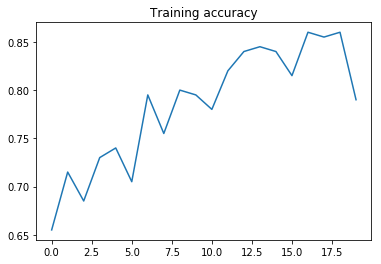

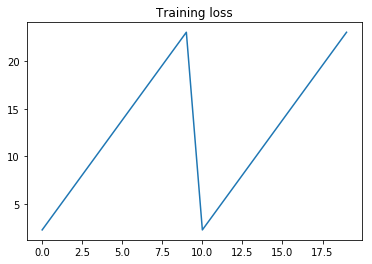

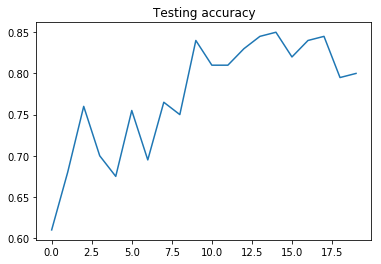

In [16]:
plt.plot(range(0, n_epochs*num_batches), trn_acc)
plt.title('Training accuracy')
plt.show()

plt.plot(range(0, n_epochs*num_batches), trn_loss)
plt.title('Training loss')
plt.show()

plt.plot(range(0, n_epochs*num_batches), tst_acc)
plt.title('Testing accuracy')
plt.show()

In [21]:

#populate the SampleMaker with all the 1000 training data from MNIST 600000 training dataset
validmaker=SampleMaker(capacity=1000)
for i in range(1000):
    p=random.randint(0, 60000)
    #print(test_dat[i].shape, test_label[i].shape)
    validmaker.push([X[p],y[p]])    

In [25]:
def valid_torch_ready(batch_size,img_size):
   
    samples=validmaker.make(batch_size)

    d,l=type_converter(samples,batch_size,img_size)
    data=torch.from_numpy(d).float()
    label=torch.from_numpy(l)
    return data , label

In [27]:
valid_acc=[]
batch_size=200
img_size=28
for i in range(50):

    d, l=valid_torch_ready(batch_size, img_size )
    valid_acc.append(evaluate(model, d, l, 200)) 
print ("validataion accuracy - ", valid_acc[-1])

C:\Users\zecharpy\AppData\Local\Continuum\anaconda3\envs\wj_py363\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


validataion accuracy -  0.765


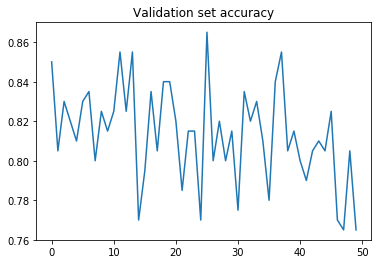

In [29]:
plt.plot(range(0, 50), valid_acc)
plt.title('Validation set accuracy')
plt.show()